# Test implementation on 1D to 1D problems
### Problem Setup
To start testing the algorithm, we are going to try to optimize finding the absolute minima of a function with
one input and one output. Lets start defining this function:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import warnings
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm

plt.style.use('dark_background')


In [2]:
# Implementation of the same algorithm using out own tool
from search_space import *
from evaluation_metrics import *

In [3]:
# objective function is to MAXIMIZE the value of the function
class ObjectiveFunction:
    def __init__(self):
        self.name = self.__class__.__name__
        self._params = None

    @property
    def params(self):
        return self._params

    @params.setter
    def params(self, params_dict):
        self._params = params_dict

    @params.deleter
    def params(self):
        del self._params

    def run(self):
	    return self.params["X"]**2 * np.sin(5 * np.pi * self.params["X"])**6

In [4]:
def random_search_optimization(search_space: SearchSpace,
                               f: ObjectiveFunction,
                               metric: callable,
                               metric_args: np.ndarray = None,
                               n_iters: int = 100,
                               ):
    explored_space = []
    X = []
    y =[]
    performances = []
    for _ in range(n_iters):
        search_space.sample()
        f.params = search_space.current
        X.append(f.params["X"])
        y.append(f.run())
        explored_space.append([X[-1], y[-1]])
        if metric_args is None:
            performances.append(metric([y[-1], 0, 0]))
        else:
            performances.append(metric([y[-1], 0, 0], metric_args))
    explored_space = np.array(explored_space)
    performances = np.array(performances)
    return explored_space, performances

In [5]:
se_dict = {
    "X": InputValueSpace(
        se_type=float_random, params_dict={"lower_bound": 0, "upper_bound": 1}
    ),
}

se = SearchSpace(input_dict=se_dict)
metric_weights = np.array([1, 0, 0])

explored_space, performances = random_search_optimization(search_space=se,
                                                          f=ObjectiveFunction(),
                                                          metric=weighted_score,
                                                          n_iters=50,
                                                          )

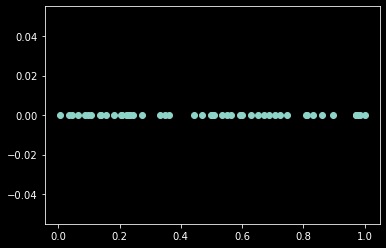

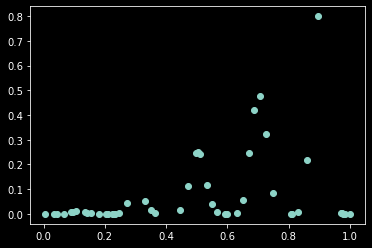

In [6]:
plt.scatter(explored_space.T[0], np.zeros(len(explored_space)))
plt.show()

plt.scatter(explored_space.T[0], performances)
plt.show()

In [7]:
## Bayesian Search

In [8]:

def bayesian_search_optimization(search_space: SearchSpace,
                                 f: ObjectiveFunction,
                                 metric: callable,
                                 metric_args: np.ndarray = None,
                                 initial_sampled_space_size: int = 100,
                                 secondary_sampled_space_size: int = 50,
                                 n_iters: int = 100,
                                 ):
    # Sample initial random space
    explored_space = []
    for _ in range(initial_sampled_space_size):
        search_space.sample()
        f.params = search_space.current
        explored_space.append([f.params["X"], f.run(), metric([f.run(), 0, 0], metric_args)])

    # Initialize the GPR model and fit it to the initial sampled space
    model = GaussianProcessRegressor()
    model.fit(np.array(explored_space).T[0].reshape(-1, 1), np.array(explored_space).T[2].reshape(-1, 1))

    for _ in range(n_iters):
        # Find optimal value from X
        y_best = np.max(np.array(explored_space).T[2])

        # Generate new (secondary) sampled space vector
        X_ = []
        y_ = []
        for _ in range(secondary_sampled_space_size):
            search_space.sample()
            f.params = search_space.current
            X_.append(f.params["X"])
            y_.append(f.run())
        X_ = np.array(X_).reshape(len(X_), 1)

        # Predict GPR values on the secondary sampled explored_space
        mu, std = model.predict(X_, return_std=True)
        mu = mu[:, 0]

        # Compute likely improvement for each space on the secondary sampled space
        probs = norm.cdf((mu - y_best) / (std + 1E-9))

        # Find best probability value and the secondary input value that generated it
        idx_best = np.argmax(probs)

        # Append best values to the main sampled space
        explored_space.append([X_[idx_best][0], y_[idx_best], metric([y_[idx_best], 0, 0], metric_args)])

        # Fit again GPR with the new added pair of values
        model.fit(np.array(explored_space).T[0].reshape(-1, 1), np.array(explored_space).T[2].reshape(-1, 1))

    explored_space = np.array(explored_space)

    return explored_space, model

In [9]:
se_dict = {
    "X": InputValueSpace(
        se_type=float_random, params_dict={"lower_bound": 0, "upper_bound": 1}
    ),
}
se = SearchSpace(input_dict=se_dict)

se = SearchSpace(input_dict=se_dict)
metric_weights = np.array([2, 100, 10])

explored_space, gbmodel = bayesian_search_optimization(search_space=se,
                                                            f=ObjectiveFunction(),
                                                            metric=weighted_score,
                                                            metric_args=metric_weights,
                                                            initial_sampled_space_size=100,
                                                            secondary_sampled_space_size=10,
                                                            n_iters=10)

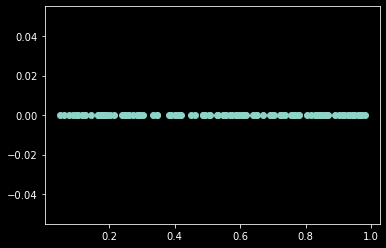

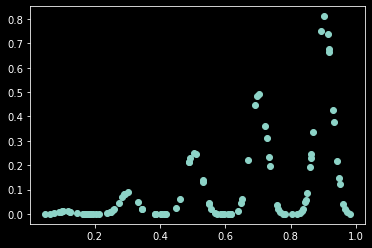

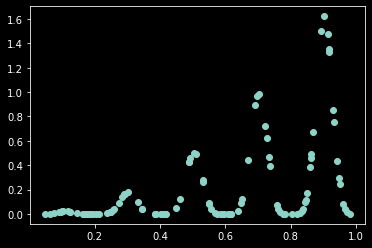

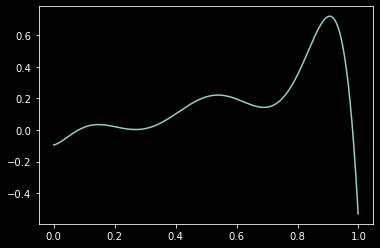

In [10]:
plt.scatter(explored_space.T[0], np.zeros(len(explored_space)))
plt.show()

plt.scatter(explored_space.T[0], explored_space.T[1])
plt.show()

plt.scatter(explored_space.T[0], explored_space.T[2])
plt.show()

X = np.arange(0, 1, 0.001)
y = gbmodel.predict(X.reshape(-1, 1))
plt.plot(X, y)
plt.show()